In [1]:
# Importa as bibliotecas necessárias
%run '~/git/Bibliotecas.ipynb'

In [2]:
print('\n\n3.1 Fertilizantes\n\n')



3.1 Fertilizantes




In [3]:
# Carrega a base de dados contendo os registros de importação de fertilizantes
i=pd.read_csv('~/git/Pricing-Fertilizer-take-Rains-into-account/temp/imp1.csv').sort_values(by=['CO_ANO','CO_MES'])
print('\nPrimeiras linhas da tabela\n')
display(i.head(2))


Primeiras linhas da tabela



,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO
0,1997,1,31042090,10,23,BA,1,517600,59,59400,10128,5824,41
1,1997,2,31043010,10,383,BA,1,517600,63,62950,25180,4950,0


In [4]:
print('\n\
Verifica-se que em cada linha da tabela é apresentada uma importação segmentada por fatores. O interesse deste projeto\n\
é somente o peso desembarcado a cada mês na Bahia e por isso todos os demais fatores serão descartados e a tabela sera\n\
agrupada em ano, mês e as quantidades de peso. Antes disso, porém, será procedida uma busca por erros, duplicatas e valores nulos\n')


Verifica-se que em cada linha da tabela é apresentada uma importação segmentada por fatores. O interesse deste projeto
é somente o peso desembarcado a cada mês na Bahia e por isso todos os demais fatores serão descartados e a tabela sera
agrupada em ano, mês e as quantidades de peso. Antes disso, porém, será procedida uma busca por erros, duplicatas e valores nulos



In [5]:
i.isna().sum().sum()

0

In [6]:
print('\nNão há valores nulos na tabela\n')


Não há valores nulos na tabela



In [7]:
i.duplicated().sum()

0

In [8]:
i.duplicated(subset=['CO_ANO','CO_MES','CO_NCM','CO_PAIS','CO_URF','SG_UF_NCM','CO_VIA']).sum()

0

Não há linhas duplicadas na tabela.

In [9]:
i[i.KG_LIQUIDO==0]

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO
118,1998,6,31021090,10,249,BA,4,117600,0,0,1320,140,0
149,1998,10,31042090,10,249,BA,4,517601,0,0,20,1,0
435,2001,9,31025090,10,249,BA,4,517601,0,0,43,1,0
483,2002,4,31042090,10,767,BA,1,517600,0,0,70,0,0
723,2004,5,31042090,10,249,BA,4,517700,0,0,230,8,0


As importações com peso zero também possuem valores próximos de zero e por isso serão todos eliminados.

In [10]:
i=i[i.KG_LIQUIDO!=0]

In [11]:
i[i.VL_FOB==0]

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO


As colunas de ano e mês são de interesse e serão mantidas.

As colunas utilizadas nas filtragens acima, CO_URF e SG_NCM_UF, tiveram a lista de seus possíveis valores reduzida, ficando estas colunas sem importância e por isso serão ambas descartadas.

Nessa primeira tentativa do projeto, em nome da simplicidade, não serão diferenciados os fertilizantes por NCM, sendo todos considerados um único produto simplesmente denominado "fertilizante". Assim, a coluna referente ao código NCM perde importância e não será mantida.

O projeto não tem plano de utilizar os dados sobre o país de origem e essa coluna será descartada.

A coluna sobre a via de transporte apresenta praticamente todos os valores ligados a via de código "1". Assim, somente registros ligados a essa via serão mantidos e a coluna será descartada.

In [12]:
i.groupby('CO_VIA')['KG_LIQUIDO'].sum().sort_values()

CO_VIA
4           1204
7          16900
1    23175956049
Name: KG_LIQUIDO, dtype: int64

In [13]:
i=i[i.CO_VIA==1]

Antes de descarta a coluna referente a via de transporte internacional, será feita uma conferência em relação a essa via ser igual ao conhecimento geral, que atribui a essa via ser marítima. Para isso será utilizada a tabela auxiliar que permite identificar nominalmente a via 1.

In [14]:
via=pd.read_csv('~/git/BD/Comexstat/VIA.csv', encoding='Latin-1',sep=';')
via.head(1)

,CO_VIA,NO_VIA
0,10,ENTRADA/SAIDA FICTA


Abaixo podemos constatar que todos os registros de importação utilizam a unidade quantitativa de código 10. Assim a coluna fica sem utilidade e será descartada. Porém , antes do descarte, confirmaremos que a unidade de valor é expressa e quilograma, como acreditamos ser.

In [15]:
i.groupby('CO_UNID')['KG_LIQUIDO'].sum().sort_values()

CO_UNID
10    23175956049
Name: KG_LIQUIDO, dtype: int64

In [16]:
unid=pd.read_csv('~/git/BD/Comexstat/NCM_UNIDADE.csv', encoding='Latin-1',sep=';')
unid.head(1)

,CO_UNID,NO_UNID,SG_UNID
0,10,QUILOGRAMA LIQUIDO,KGL


A coluna 'QT_STAT' representa a quantidade importada expressa em unidades utilizadas no país de origem, que podem ser diferentes de quilograma. Isso não é de interesse do projeto e a coluna também será descartada.

In [17]:
i[i.KG_LIQUIDO<=0]

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO


In [18]:
print('\n\nAnálise Visual de Normalidade:\n\
Será executada utilizando-se apenas "5 bins", sendo de conhecimento do autor que muito mais limpezas poderiam fazer.\n\
É bom lembrar que o objetivo do trabalho não é fazer a precisão mais precisa possível e sim comparar previsão com e sem chuva.\n\n')



Análise Visual de Normalidade:
Será executada utilizando-se apenas "5 bins", sendo de conhecimento do autor que muito mais limpezas poderiam fazer.
É bom lembrar que o objetivo do trabalho não é fazer a precisão mais precisa possível e sim comparar previsão com e sem chuva.




KG_LÍQUIDO

Text(0.5, 1.1, 'Importação de Fertilizantes na Bahia')

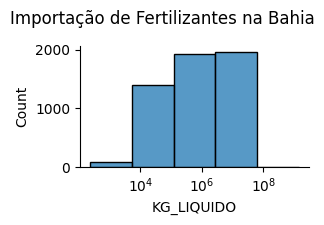

In [19]:
sns.displot(height=2, aspect=1.618,data=i,x='KG_LIQUIDO', bins=5, log_scale=True).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)

Text(0.5, 1.1, 'Importação de Fertilizantes na Bahia')

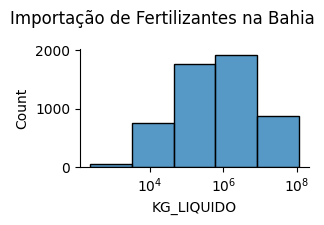

In [20]:
id_err=i[i.KG_LIQUIDO==i.KG_LIQUIDO.max()].loc[:,:'CO_URF'].drop(columns=['CO_MES'])

i['FOB_ton']=i.VL_FOB/(i.KG_LIQUIDO/1000)

preço_corrigdo=i[i.CO_MES.isin([7,9])].merge(id_err)['FOB_ton'].mean()

i.loc[i.KG_LIQUIDO==i.KG_LIQUIDO.max(),'FOB_ton']=preço_corrigdo

i.loc[i.KG_LIQUIDO==i.KG_LIQUIDO.max(),'KG_LIQUIDO']=i[i.KG_LIQUIDO==i.KG_LIQUIDO.max()].VL_FOB/i[i.KG_LIQUIDO==i.KG_LIQUIDO.max()]['FOB_ton']

sns.displot(height=2, aspect=1.618,data=i,x='KG_LIQUIDO', bins=5, log_scale=True).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)

VL_FOB

Text(0.5, 1.1, 'Importação de Fertilizantes na Bahia')

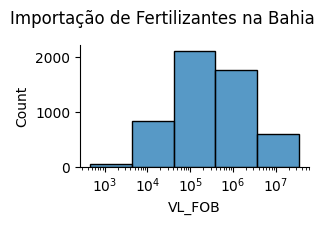

In [21]:
sns.displot(height=2, aspect=1.618,data=i,x='VL_FOB', bins=5, log_scale=True).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)

FOB_ton

Text(0.5, 1.1, 'Importação de Fertilizantes na Bahia')

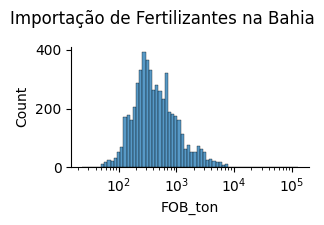

In [22]:
sns.displot(height=2, aspect=1.618,data=i,x='FOB_ton', log_scale=True).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)

In [23]:
i.head(1)

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO,FOB_ton
0,1997,1,31042090,10,23,BA,1,517600,59,59400.0,10128,5824,41,170.505051


In [24]:
i=i.groupby(by=['CO_ANO','CO_MES'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()

In [25]:
i['FOB_ton']=i.VL_FOB/(i.KG_LIQUIDO/1000)

In [26]:
i=i.drop(columns=['KG_LIQUIDO','VL_FOB'])

Text(0.5, 1.1, 'Importação de Fertilizantes na Bahia')

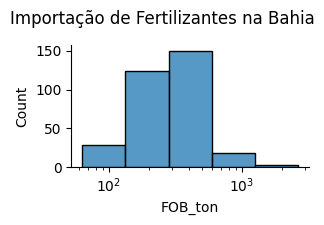

In [27]:
sns.displot(height=2, aspect=1.618,data=i,x='FOB_ton',bins=5, log_scale=True).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)

In [28]:
i[i.FOB_ton>10**3]

,CO_ANO,CO_MES,FOB_ton
78,2003,8,2653.687138
140,2008,10,1005.740572
141,2008,11,1397.860671
142,2008,12,1257.145980


In [29]:
i.loc[i.FOB_ton==i.FOB_ton.max(),'FOB_ton']=10**3

In [30]:
# Cria luna com a data completa e no formato apropriado
i['date']=pd.to_datetime(i.CO_ANO.astype(str)+'/'+i.CO_MES.astype(str)+'/1')

In [31]:
k=i.groupby('CO_ANO').CO_MES.unique().reset_index()[['CO_ANO','CO_MES']].values

df=pd.DataFrame(k,columns=['ANO','MES'])

# Função para obter o número de itens em uma lista
def contar_itens(lista):
    return len(lista)

# Aplicar a função à coluna e armazenar o resultado na nova coluna
df['num_itens_lista'] = df['MES'].apply(contar_itens)

df

,ANO,MES,num_itens_lista
0,1997,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12
1,1998,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12
2,1999,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12
3,2000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12
4,2001,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12
5,2002,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",11
6,2003,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12
7,2004,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12
8,2005,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12
9,2006,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12


Para utilizar um processamento simples, não pode ser aceito mês sem importação no conjunto de dados.

A último mês onde não houve importação foi 01/2002. Portanto, todos as datas, inclusive esta, serão descartadas do projeto.

In [32]:
i=i[i.CO_ANO>=2009]

In [33]:
i.to_csv('~/git/Pricing-Fertilizer-take-Rains-into-account/temp/i.csv',index=False)

In [34]:
print('\n\n3.2 Chuvas\n\n')



3.2 Chuvas




In [35]:
# Importa as bibliotecas necessárias
%run '~/git/Bibliotecas.ipynb'

In [36]:
# Carrega a tabela com histórico das chuvas no oeste baiano
c=pd.read_csv('/home/andre301267/git/Pricing-Fertilizer-take-Rains-into-account/temp/chuvas1.csv')
#c.sort_values('date').head(1)

Seleciona colunas de interesse e unifica colunas que estão em duplicidade.

In [37]:
c=c[c.columns[[20,0,21,1,22,2]]]
c.columns=['Estação','date1','date2','hora1','hora2','mm']
c.date1=pd.to_datetime(c.date1+'-'+c.hora1)
c.date2=pd.to_datetime(c.date2+'-'+c.hora2)
c['date']=pd.to_datetime(pd.concat([c.date1.dropna(),c.date2.dropna()]), utc=True)
c['CO_ANO']=c.date.dt.year
c['CO_MES']=c.date.dt.month
c['Dia']=c.date.dt.day
c['Hora']=c.date.dt.hour
c=c[c.columns[[0,6,7,8,9,10,5]]].sort_values(by='date')

In [38]:
print('A tabela Chuvas:')
display(c.head(3))

A tabela Chuvas:


,Estação,date,CO_ANO,CO_MES,Dia,Hora,mm
165264,BARREIRAS,2001-12-20 00:00:00+00:00,2001,12,20,0,-9999
165265,BARREIRAS,2001-12-20 01:00:00+00:00,2001,12,20,1,-9999
165266,BARREIRAS,2001-12-20 02:00:00+00:00,2001,12,20,2,-9999


In [39]:
c.Estação=c.Estação.str.capitalize()

In [40]:
print(f"\
\nApós as limpezas e correções necessárias, com base em \
{len(c.Estação.unique().tolist())} estações meteorológicas\n\
,{','.join(c.Estação.unique())}, através de medianas,\n\
se definirá uma única sequência de registros de chuva que representará a região do oeste baiano.\n\n\
Os registros estão originalmente executados por hora mas deverão ser expressos no mesmo formato de tempo\n\
usado pela tabela de importação, que expressa tempo em mês.\n\n")


Após as limpezas e correções necessárias, com base em 4 estações meteorológicas
,Barreiras,Luiz eduardo magalhaes,Correntina,Formosa do rio preto, através de medianas,
se definirá uma única sequência de registros de chuva que representará a região do oeste baiano.

Os registros estão originalmente executados por hora mas deverão ser expressos no mesmo formato de tempo
usado pela tabela de importação, que expressa tempo em mês.




In [41]:
c.loc[c.mm=='-9999','mm']=np.nan
c.mm=c.mm.str.replace(',','.')
c.mm=c.mm.astype('float')

In [42]:
c.duplicated().sum()

0

In [43]:
c.isna().sum()

Estação         0
date            0
CO_ANO          0
CO_MES          0
Dia             0
Hora            0
mm         103001
dtype: int64

In [44]:
c_na=c[(c.mm.isna())]
c_not_na=c[~(c.mm.isna())]

A seguir se modifica a tabela com falhas no registro de forma a permitir a análise gráfica da distribuição das falhas ao longo das categorias existentes, com objetivo de verificar se há algum relacionamento lógico para as ocorrências.

A seguir analizaremos a normalidade da distribuição dos registros de chuva. A cada aprovação de normalidade, se elimina a menor subdivisão de tempo, reagrupando, até chegar na subdvisão de tempo por mês, que é a medida de tempo foco deste projeto.

In [45]:
# Cria nova coluna com volume de chuva em unidade logarítmica
c_not_na['mm_hora_log']=np.log10(c_not_na.mm)

In [46]:
c_dia=c_not_na.groupby(by=c_not_na.columns[[0,1,2,3,4]].tolist())[['mm']].sum().reset_index()
c_dia.head(1)

,Estação,date,CO_ANO,CO_MES,Dia,mm
0,Barreiras,2001-12-20 15:00:00+00:00,2001,12,20,2.0


In [47]:
c_dia['mm_dia_log']=np.log10(c_dia.mm)

Nos dois gráficos apresentados acima podemos notar:  

> Devido a grande amplitude nos volumes de chuvas registrados, para possibilitar a visualização da curva normal, foi necessário aplicar duas vezes seguidas a transformação logarítmica aos volumes de chuva:
> * primeiro: transformando diretamente o valor medido para logarítmo
> * segundo: utilizando no gráfico a escala logarítmica

Agrupa-se a tabela por mês

In [48]:
c_mes=c_dia.groupby(by=['Estação','CO_ANO','CO_MES']).mm.sum().reset_index().rename(columns={'mm':'mm_mes'})

Com os agrupamentos até aqui procedidos, não é mais necessário a dupla transofrmação logaritmica, mas ainda é necessário a escala logarítmica no gráfico, para se visualizar a curva normal d distribuição de chuvas por mês.

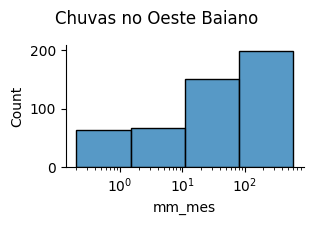

In [49]:
sns.displot(height=2, aspect=1.618,data=c_mes[c_mes.mm_mes!=0],x='mm_mes',log_scale=True, bins=4).fig.suptitle('Chuvas no Oeste Baiano',y=1.1)
plt.show()

Para simplificar, levaremos em conta apenas um linha do tempo de registros de chuva, sendo a seguir eleiminada a subdivisão referente as estações meteorológicas e agrupando os dados utilizando os valores medianos entre as estações.

Após realizar todos os agrupamentos necessários até alcançar a unidade de tempo desejada, por fim, os dados são considerados normais.

In [50]:
# Cria coluna com data completa e no formato adequado
c['date']=pd.to_datetime(c.CO_ANO.astype(str)+'/'+c.CO_MES.astype(str)+'/1')

In [51]:
# Cria matriz esparsa, com o mesmo objetivo do que foi feito com a tabela de imortações
c_ini=c.date.iloc[0]
c_fim=c.date.iloc[-1]
c[['CO_ANO','CO_MES']]=c[['CO_ANO','CO_MES']].astype('category')
c=c.groupby(by=['CO_ANO','CO_MES']).mm.sum().reset_index()
c[['CO_ANO','CO_MES']]=c[['CO_ANO','CO_MES']].astype('int')
c['date']=pd.to_datetime(c.CO_ANO.astype(str)+'/'+c.CO_MES.astype(str)+'/1')
c=c[(c.date>=c_ini)&(c.date<=c_fim)]
c=c.sort_values(by=['date'])
c

,CO_ANO,CO_MES,mm,date
11,2001,12,23.2,2001-12-01
12,2002,1,0.0,2002-01-01
13,2002,2,0.0,2002-02-01
14,2002,3,28.0,2002-03-01
15,2002,4,35.6,2002-04-01
...,...,...,...,...
271,2023,8,59.4,2023-08-01
272,2023,9,15.0,2023-09-01
273,2023,10,189.0,2023-10-01
274,2023,11,159.2,2023-11-01


Análise de tendência de longo prazo nos volumes de chuva

Visualmente as chuvas não apresentam tendência de longo prazo.

In [52]:
c.to_csv('~/git/Pricing-Fertilizer-take-Rains-into-account/temp/c.csv',index=False)

In [53]:
print('\n\n 3.3 União de Importações e Chuvas\n\n')



 3.3 União de Importações e Chuvas




In [54]:
# Importa as bibliotecas necessárias
%run '~/git/Bibliotecas.ipynb'
from sklearn.preprocessing import MinMaxScaler as mms
mms=mms()
from sklearn import metrics

In [55]:
# Carrega as tabelas
i=pd.read_csv('~/git/Pricing-Fertilizer-take-Rains-into-account/temp/i.csv')
c=pd.read_csv('~/git/Pricing-Fertilizer-take-Rains-into-account/temp/c.csv')

# Funde as tabelas
i_c=i.merge(c)

# Seleciona e ordena as colunas
i_c=i_c[i_c.columns[[3,0,1,2,4]]]
i_c.date=pd.to_datetime(i_c.date)
i_c.head(1)

,date,CO_ANO,CO_MES,FOB_ton,mm
0,2009-01-01,2009,1,174.024443,398.6


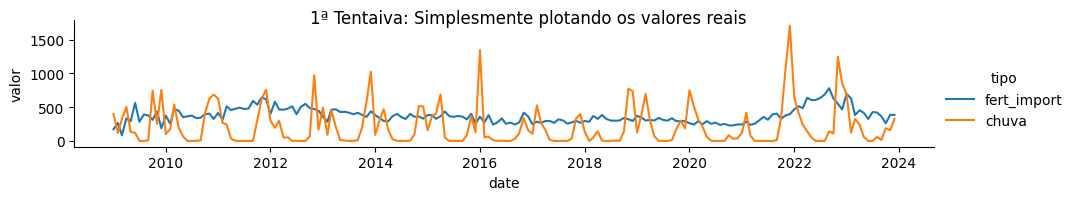

In [56]:
icl=pd.concat([
    i_c[['date','FOB_ton']].rename(columns={'FOB_ton':'valor'}).assign(tipo='fert_import'),
    i_c[['date','mm'        ]].rename(columns={'mm'        :'valor'}).assign(tipo='chuva')
])                         
sns.relplot(data=icl,x='date',y='valor',hue='tipo', kind='line',height=2,aspect=3*1.6).fig.suptitle(f'1ª Tentaiva: Simplesmente plotando os valores reais')
plt.show()

In [57]:
print('\nImpraticável visualização\n')


Impraticável visualização



Quando simplesmente comparamos as chuvas com as importações, como nessa primeira tentativa, percebemos que os dados e chuva ficam achatados na parte inferior do gráfico, sem possibilitar visualizar as variações. Isso ocorre em função da diferença de escala, que será resolvida a seguir, com o reescalonamento dos valores para uma faixa de 0 a 1, com zero sendo o menor e 1 o maior valor de cada fonte de dado.  

Outra diferença entre os valores é que as importações apresentam uma tendência visual de crescimento ao longo dos anos, fato que não ocorre com as chuvas, já que o clima é mais constante do que a economia no longo prazo. Isso também será resolvido calculando-se a tendência central dos fertilizantes, que é a regressão linear, e extraindo-se ela dos valores.

In [58]:
print('\n\n2ª Tentaiva: Extrai a tendência anual dos fertilizantes e rescalona os valores\n\n\
Devido ao vetores da economia, as importações apresentam tendência ao longo dos anos. As chuvas, não.\n\n')



2ª Tentaiva: Extrai a tendência anual dos fertilizantes e rescalona os valores

Devido ao vetores da economia, as importações apresentam tendência ao longo dos anos. As chuvas, não.




In [59]:
i_c['FOB_ton_tend']=np.poly1d(np.polyfit(i_c.date.astype(int),i_c.FOB_ton, deg=1))(i_c.date.astype(int))

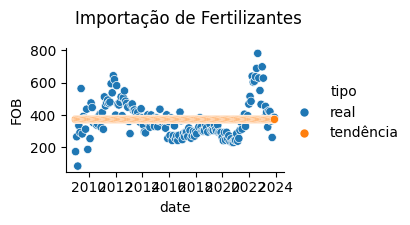

In [60]:
i_c_l=pd.concat([
    i_c[['date','FOB_ton']].assign(tipo='real').rename(columns={'FOB_ton':'FOB'}),
    i_c[['date','FOB_ton_tend']].assign(tipo='tendência').rename(columns={'FOB_ton_tend':'FOB'})
])

sns.relplot(data=i_c_l,y='FOB',x='date',height=2,aspect=1.6,hue='tipo').fig.suptitle('Importação de Fertilizantes',y=1.1)
plt.show()

In [61]:
i_c['FOB_ton_flat']=i_c.FOB_ton/i_c.FOB_ton_tend*i_c.FOB_ton_tend.min()

In [62]:
i_c[['FOB_ton_flat_scaled','chuva_scaled']]=mms.fit_transform(i_c[['FOB_ton_flat','mm']])

In [63]:
print('\n\nVisualizando os valores transformados\n\n')



Visualizando os valores transformados




In [64]:
i_c

,date,CO_ANO,CO_MES,FOB_ton,mm,FOB_ton_tend,FOB_ton_flat,FOB_ton_flat_scaled,chuva_scaled
0,2009-01-01,2009,1,174.024443,398.6,373.259720,173.919160,0.128164,0.233948
1,2009-02-01,2009,2,265.825358,119.0,373.258434,265.665452,0.260106,0.069844
2,2009-03-01,2009,3,84.850231,324.0,373.257274,84.799453,0.000000,0.190163
3,2009-04-01,2009,4,334.667870,503.8,373.255988,334.468744,0.359053,0.295692
4,2009-05-01,2009,5,292.176995,132.8,373.254745,292.004124,0.297984,0.077943
...,...,...,...,...,...,...,...,...,...
175,2023-08-01,2023,8,421.169760,59.4,373.038961,421.164049,0.483731,0.034863
176,2023-09-01,2023,9,363.433582,15.0,373.037676,363.429906,0.400703,0.008804
177,2023-10-01,2023,10,261.316500,189.0,373.036432,261.314729,0.253849,0.110929
178,2023-11-01,2023,11,385.976635,159.2,373.035147,385.975348,0.433126,0.093438


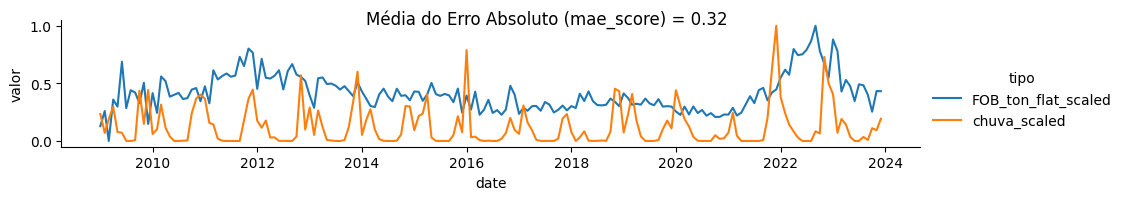

In [65]:
icl=pd.concat([
    i_c[['date','FOB_ton_flat_scaled']].rename(columns={'FOB_ton_flat_scaled':'valor'}).assign(tipo='FOB_ton_flat_scaled'),
    i_c[['date','chuva_scaled'      ]].rename(columns={'chuva_scaled':'valor'      }).assign(tipo='chuva_scaled'      )
              ]) 
score=round(metrics.mean_absolute_error(i_c.FOB_ton_flat_scaled,i_c.chuva_scaled),2)

sns.relplot(data=icl,x='date',y='valor',hue='tipo', kind='line',height=2,aspect=3*1.6).fig.suptitle(f'Média do Erro Absoluto (mae_score) = {score}')
plt.show()

In [66]:
print('\n\n\
Conforme dito, as chuvas não podem afetar as importações no mesmo mês em que elas precipitaram, já que o produto\n\
a caminho não pode voltar. Então é necessário ainda testar o impacto da chuva em relação a meses posteriores.\n\n\
É bom observar que o erro absoluto médio nesta situação para em seguida comparamos com os erros calculados com as\n\
datas das chuvas adiantadas.\n\n')



Conforme dito, as chuvas não podem afetar as importações no mesmo mês em que elas precipitaram, já que o produto
a caminho não pode voltar. Então é necessário ainda testar o impacto da chuva em relação a meses posteriores.

É bom observar que o erro absoluto médio nesta situação para em seguida comparamos com os erros calculados com as
datas das chuvas adiantadas.




Nesta tentativa acima podemos ver as variações de chuvas e fertilizantes numa mesma escala e já podemos notar semelhança no formato delas, o que indica que estamos "no caminho certo". A distância vertical média entre os registros de chuva e importação ou, a média do erro absoluto (mae_score) foi determinada, e será base de comparação numérica com as tentaivas a seguir.

Esse projeto se propõe, de certa forma, a responder se as curvas das chuvas acima induzem ou não as curvas de importação, numa relação de causa e efeito. Um fato que causa o outro deve acontecer antes do outro, além de ter magnitude proporcional. Então, para comparar a chuva com as importações, a seguir, repetidamente, os registros de chuva terão sua data alterada, somando-se a ela 1 mês a cada avaliação, buscando sobrepor as curvas o tanto quanto possível. Quando essa sobreposição for máxima, a média de erro entre uma curva e outra alcançará o seu menor valor.

3ª tentaiva: Adiantando as chuvas nos meses até antes completar 1 ano de avanço

In [67]:
q=pd.DataFrame()

def ad_plot(df):
    '''Plota os valores escalonados'''

    global q
    
    global i_c
    
    i_c=ad(df)
    
    score=round(metrics.mean_absolute_error(i_c.FOB_ton_flat_scaled,i_c.chuva_scaled),2)

    r=pd.DataFrame({'Antecedência da chuva em\nrelação a importação (meses)':[adi],'mae_fertiliz_chuva':[score]})

    q=pd.concat([q,r])
    
    icl=pd.concat([df[['date','FOB_ton_flat_scaled']].rename(columns={'FOB_ton_flat_scaled':'valor'}).assign(tipo='FOB_ton_flat_scaled'),
                   df[['date','chuva_scaled']].rename(columns={'chuva_scaled':'valor'}).assign(tipo='chuva_scaled')]) 
    
    sns.relplot(data=icl,x='date',y='valor',hue='tipo', kind='line',height=2,aspect=3*1.6)\
    .fig.suptitle(f'Bahia - Registro de Chuva Adiantado em {adi} mês, mae_score={score}')
    
    plt.show()

In [68]:
def ad(df):
    '''Adianta 1 mês os registros de chuva'''
    ic_f=df.drop(columns=['mm','chuva_scaled'])
    ic_c=df.drop(columns=['FOB_ton','FOB_ton_tend','FOB_ton_flat','FOB_ton_flat_scaled'])
    ic_c.CO_MES=df.CO_MES+1
    ic_c.loc[ic_c.CO_MES==13,'CO_ANO']=ic_c[ic_c.CO_MES==13].CO_ANO+1
    ic_c.loc[ic_c.CO_MES==13,'CO_MES']=1
    ic_c.date=pd.to_datetime(ic_c.CO_ANO.astype(str)+'/'+ic_c.CO_MES.astype(str)+'/1')
    df=ic_c.merge(ic_f)
    return df

In [69]:
i_c

,date,CO_ANO,CO_MES,FOB_ton,mm,FOB_ton_tend,FOB_ton_flat,FOB_ton_flat_scaled,chuva_scaled
0,2009-01-01,2009,1,174.024443,398.6,373.259720,173.919160,0.128164,0.233948
1,2009-02-01,2009,2,265.825358,119.0,373.258434,265.665452,0.260106,0.069844
2,2009-03-01,2009,3,84.850231,324.0,373.257274,84.799453,0.000000,0.190163
3,2009-04-01,2009,4,334.667870,503.8,373.255988,334.468744,0.359053,0.295692
4,2009-05-01,2009,5,292.176995,132.8,373.254745,292.004124,0.297984,0.077943
...,...,...,...,...,...,...,...,...,...
175,2023-08-01,2023,8,421.169760,59.4,373.038961,421.164049,0.483731,0.034863
176,2023-09-01,2023,9,363.433582,15.0,373.037676,363.429906,0.400703,0.008804
177,2023-10-01,2023,10,261.316500,189.0,373.036432,261.314729,0.253849,0.110929
178,2023-11-01,2023,11,385.976635,159.2,373.035147,385.975348,0.433126,0.093438


In [70]:
print('\n\n\
Conclusão:\n\
Visualmente os volumes de chuvas parecem induzir variações nas importações de fertilizantes.\n\
O menor erro absoluto calculado ocorreu aos 7 meses após sua incidência das chuvas.\n\n\
A suavidade dos movimentos da linha traçada no último gráfico acima faz crer não representar um movimento aleatório.\n\n\
No próximo capítulo montaremos um teste para saber se podemos afirmar isso com confiança estatística.\n\n')



Conclusão:
Visualmente os volumes de chuvas parecem induzir variações nas importações de fertilizantes.
O menor erro absoluto calculado ocorreu aos 7 meses após sua incidência das chuvas.

A suavidade dos movimentos da linha traçada no último gráfico acima faz crer não representar um movimento aleatório.

No próximo capítulo montaremos um teste para saber se podemos afirmar isso com confiança estatística.




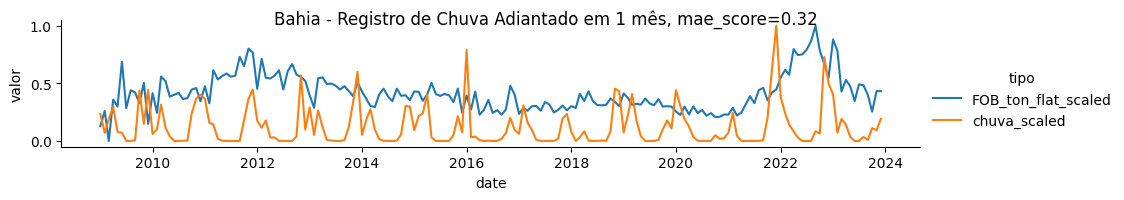

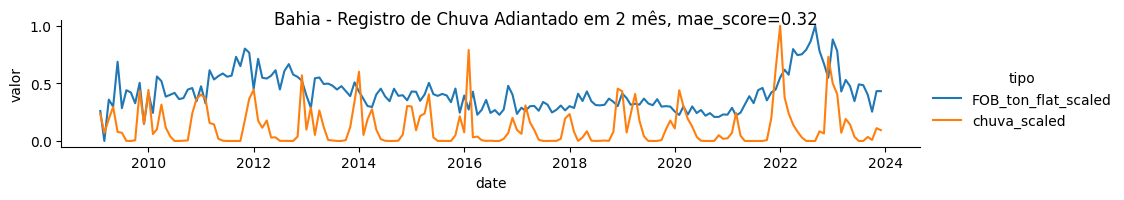

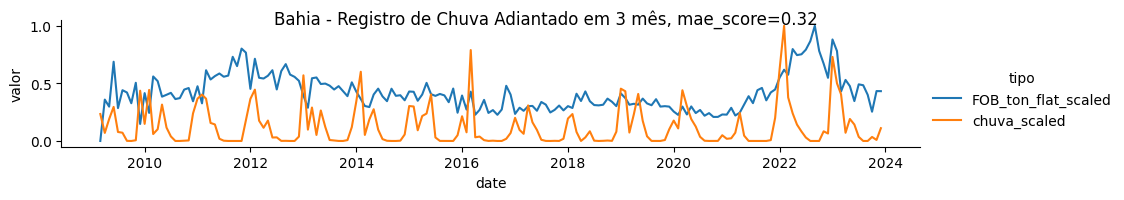

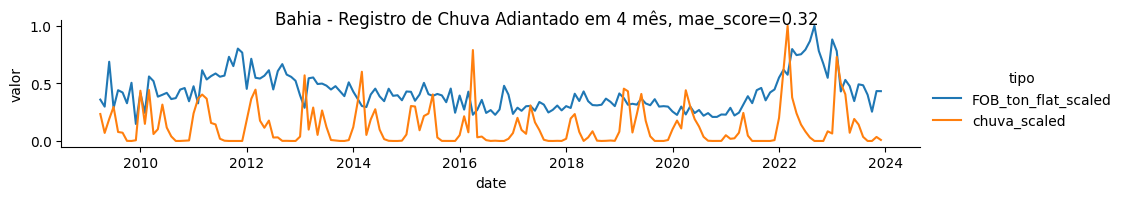

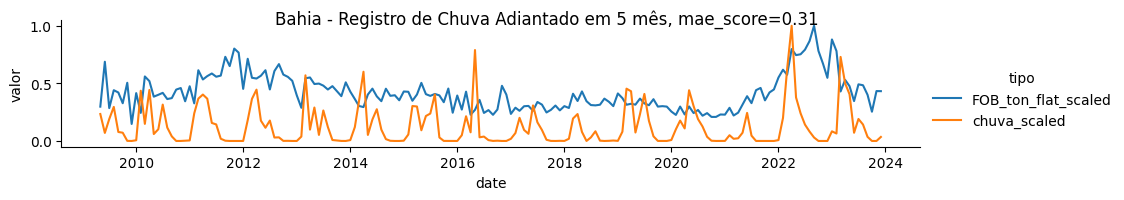

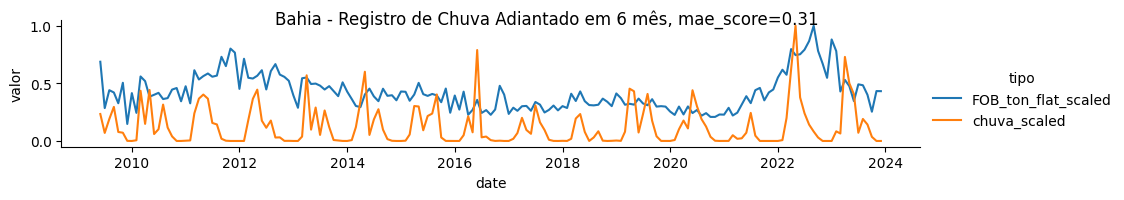

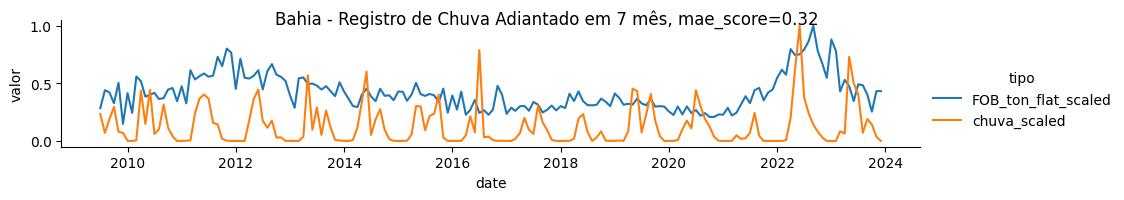

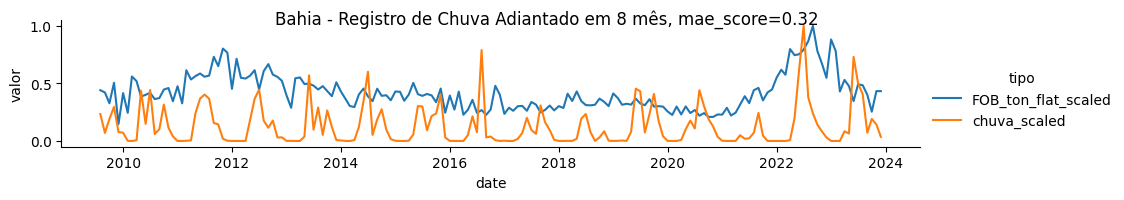

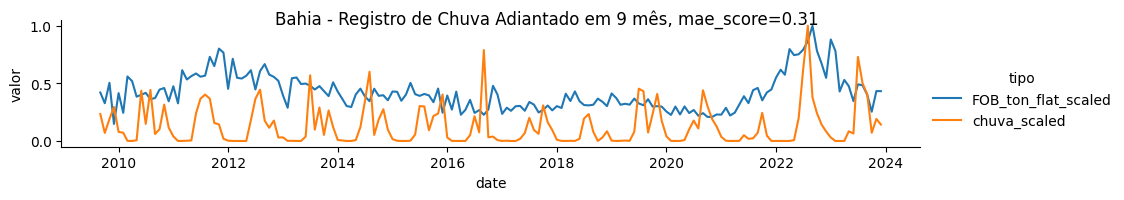

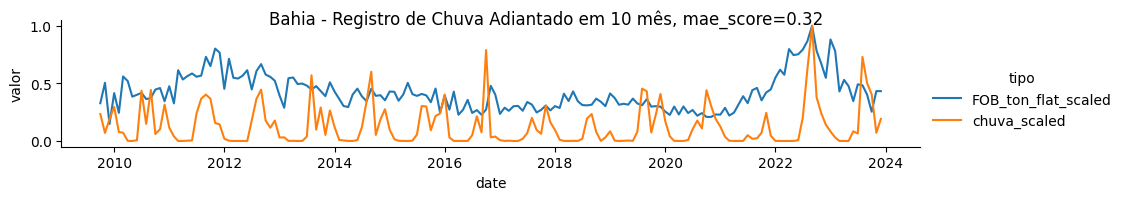

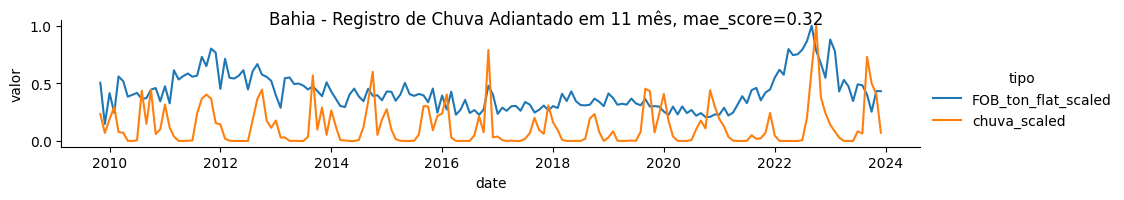

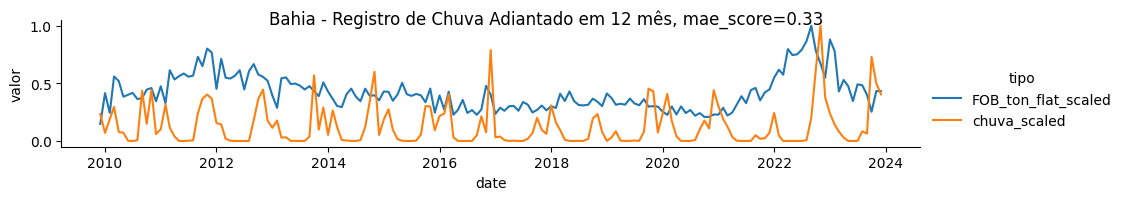

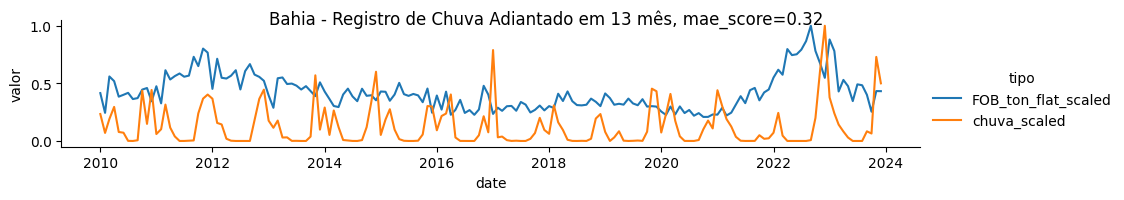

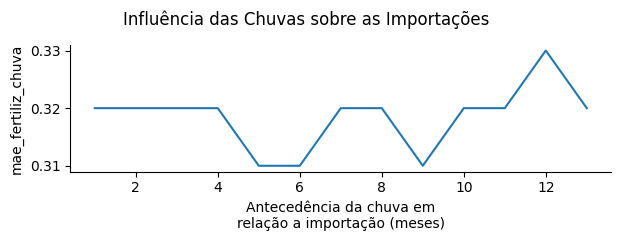

In [71]:
for adi in range(1,14):
    ad_plot(i_c)
sns.relplot(data=q,x='Antecedência da chuva em\nrelação a importação (meses)',y='mae_fertiliz_chuva',kind='line', height=2,aspect=2*1.6)\
.fig.suptitle('Influência das Chuvas sobre as Importações',y=1.1)
plt.show()